In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import copy
import holidays
import datetime as dt
from datetime import timedelta
os.getcwd()
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import multilabel_confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import catboost as cb
import math
from imblearn.over_sampling import SMOTE, SVMSMOTE, KMeansSMOTE

import shap
shap.initjs()

pd.set_option('display.max_columns', 70)

In [2]:
# read in punctuality data
punct2019_1 = pd.read_csv("./data/Punctuality_2019_part1.csv", sep = ";")
punct2019_2 = pd.read_csv("./data/Punctuality_2019_part2.csv", sep = ";")
punct2020_1 = pd.read_csv("./data/Punctuality_2020_part1.csv", sep = ";")
punct2020_2 = pd.read_csv("./data/Punctuality_2020_part2.csv", sep = ";")
punct2021_1 = pd.read_csv("./data/Punctuality_2021_part1.csv", sep = ";")
punct2021_2 = pd.read_csv("./data/Punctuality_2021_part2.csv", sep = ";")
punct2022_1 = pd.read_csv("./data/Punctuality_2022_part1.csv", sep = ";")
punct2022_2 = pd.read_csv("./data/Punctuality_2022_part2.csv", sep = ";")
punct2023 = pd.read_csv("./data/Punctuality_2023.csv", sep = ";")
all_punct = pd.concat([punct2019_1, punct2019_2, punct2020_1, punct2020_2, punct2021_1, punct2021_2, punct2022_1, punct2022_2, punct2023], axis = 0)
all_punct = all_punct[all_punct['TRAIN_ID'].notna()].reset_index()

# read in justifications data
justifs = pd.read_parquet("~/Downloads/justif_parquet")
justifs = justifs[justifs['TRAIN_ID_resp'].notna()]
justifs['p_resp'] = justifs['trno_resp'].apply(lambda x: 1 if ((x >= 7000) & (x <= 8999)) else 0)

# duplicate columns of interest to update with info from the train that was ultimately responsable for the knock-on delay
justifs['justification_dt_originator'] = justifs['justification_dt']
justifs['trno_resp_originator'] = justifs['trno_resp']
justifs['TRAIN_ID_resp_originator'] = justifs['TRAIN_ID_resp']


## Getting the label - preparation: we transform justifs to account for knock-on delays

In [ ]:
# check potential overlap (in reality can be even more as uniqueness is not required)

unique_impacted = pd.unique(justifs['REF_TOD_IMPACTED_TRAIN'])
unique_responsible_originator = pd.unique(justifs['TRAIN_ID_resp_originator'])
print(len(unique_impacted)) # 293355
print(len(unique_responsible_originator)) # 268046
#common_elements = [element for element in unique_responsible_originator if element in unique_impacted] # takes a minute
#print(len(common_elements)) # 112818

293355
268046
112818


In [ ]:
justifs[['DEPARTURE_DT', 'TRAIN_NUMBER', 'REF_TOD_IMPACTED_TRAIN', 'JUSTIFIED_DIFFERENTIAL_DELAY', 'justification_dt',
         'trno_resp', 'TRAIN_ID_resp', 'justification_dt_originator', 'trno_resp_originator', 'TRAIN_ID_resp_originator']]

,DEPARTURE_DT,TRAIN_NUMBER,REF_TOD_IMPACTED_TRAIN,JUSTIFIED_DIFFERENTIAL_DELAY,justification_dt,trno_resp,TRAIN_ID_resp,justification_dt_originator,trno_resp_originator,TRAIN_ID_resp_originator
0,2019-09-26,1707,24192376,2,2019-09-26 09:01:51,7574.0,24196802.0,2019-09-26 09:01:51,7574.0,24196802.0
1,2020-01-07,9251,24786498,2,2020-01-07 15:50:04,8600.0,24788833.0,2020-01-07 15:50:04,8600.0,24788833.0
2,2019-02-25,1528,22936396,2,2019-02-25 07:36:39,7054.0,22940978.0,2019-02-25 07:36:39,7054.0,22940978.0
3,2019-03-18,2304,23057298,2,2019-03-18 07:28:47,7006.0,23058491.0,2019-03-18 07:28:47,7006.0,23058491.0
4,2019-09-05,437,24062554,2,2019-09-05 16:39:22,8801.0,24065964.0,2019-09-05 16:39:22,8801.0,24065964.0
...,...,...,...,...,...,...,...,...,...,...
724219,2022-05-02,565,30224546,2,2022-05-02 18:04:11,8972.0,30222279.0,2022-05-02 18:04:11,8972.0,30222279.0
724220,2022-03-29,7362,29999779,1,2022-03-29 08:43:07,2855.0,30001588.0,2022-03-29 08:43:07,2855.0,30001588.0
724221,2022-03-29,507,30001637,1,2022-03-29 12:42:07,7009.0,30000162.0,2022-03-29 12:42:07,7009.0,30000162.0
724225,2022-04-11,3919,30084539,9,2022-04-11 19:32:11,8766.0,30083107.0,2022-04-11 19:32:11,8766.0,30083107.0


In [ ]:
# Add priors column to keep track of how many times a row has been updated
justifs["priors"] = 0


# Loop through each row
for i, row in justifs.iterrows():
    # Get the initial row justification_dt, trno_resp, and TRAIN_ID_resp
    initial_dt = row["justification_dt_originator"]
    initial_trno = row["trno_resp_originator"]
    initial_train_id = row["TRAIN_ID_resp_originator"]
    priors = 0
    
    # Look for a prior row
    # Set flag to True initially to enter the while loop
    has_prior_row = True
    
    while has_prior_row:
        prior_row = justifs[(justifs["REF_TOD_IMPACTED_TRAIN"] == initial_train_id) & 
                      (justifs["justification_dt"] < initial_dt) & 
                      (justifs["justification_dt"] >= initial_dt - timedelta(minutes=5))]
        
        # If a prior row exists, update the initial row with its values
        if not prior_row.empty:
            prior_row = prior_row.iloc[-1]  # Get the most recent prior row
            justifs.at[i, "justification_dt_originator"] = prior_row["justification_dt"]
            justifs.at[i, "trno_resp_originator"] = prior_row["trno_resp"]
            justifs.at[i, "TRAIN_ID_resp_originator"] = prior_row["TRAIN_ID_resp"]
            priors += 1
            initial_dt = prior_row["justification_dt"]
            initial_trno = prior_row["trno_resp"]
            initial_train_id = prior_row["TRAIN_ID_resp"]
        else:
            has_prior_row = False
            
    # Update priors column for the current row
    justifs.at[i, "priors"] = priors

# check
justifs[['DEPARTURE_DT', 'TRAIN_NUMBER', 'REF_TOD_IMPACTED_TRAIN', 'JUSTIFIED_DIFFERENTIAL_DELAY', 'justification_dt',
         'trno_resp', 'TRAIN_ID_resp', 'justification_dt_originator', 'trno_resp_originator', 'TRAIN_ID_resp_originator', 'priors']]

,REF_JUS_ID,IMPACTED_TRAIN_DEPARTURE_DT,IMPACTED_TRAIN_LABEL,REF_TOD_IMPACTED_TRAIN,PTCAR_NO,DISTURBANCE_DT,JUSTIFIED_DIFFERENTIAL_DELAY,DISTURBANCE_ID,REF_DOSSIER,REF_JUSTIFICATION_NO,DemandJustifyType,TRAIN_NUMBER,NAT_RGE,DEPARTURE_DT,PassengerTrain,REF_OPE_NO,COMMERCIAL_TYPE,LONG_NAME_NL,LONG_NAME_FR,GPS_LATITUDE,GPS_LONGITUDE,DISTRICT_ID,DISTURB_TYPE_ID,type_fr,type_nl,groupe_fr,groupe_nl,TRAIN_ID_resp,Libelle_resp,trno_resp,nat_rge_resp,RSP_NB,rsp_nb2,Disturb_id2,DOSSIER_NO,dossier_type2,master_dossier_ref2,ELEMENT,REPORT,DATUM,type_fr2,type_nl2,groupe_fr2,groupe_nl2,justification_dt,DOSSIER_REF,PTR_PTCAR_NO,LIN_LIGN_ID,REF_LINE_NO,LINE_NUMBER,IDENTIFICATOR,p_resp,justification_dt_originator,trno_resp_originator,TRAIN_ID_resp_originator,priors
0,26460201,2019-09-26,E1707,24192376,215,2019-09-26 09:01:51,2,29864904,0,18574998,Delay,1707,,2019-09-26,1:train with passengers,SNCB/NMBS,IC,BRUSSEL-CENTRAAL,BRUXELLES-CENTRAL,50.845175,4.357131,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,24196802.0,7574,7574.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2019-09-26 09:01:51,NaN,NaN,NaN,NaN,NaN,None,1,2019-09-26 09:01:51,7574.0,24196802.0,0
1,27027204,2020-01-07,EE9251,24786498,215,2020-01-07 15:50:03,2,30965100,0,19303584,Delay,9251,,2020-01-07,1:train with passengers,SNCB/NMBS,IC,BRUSSEL-CENTRAAL,BRUXELLES-CENTRAL,50.845175,4.357131,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,24788833.0,8600,8600.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2020-01-07 15:50:04,NaN,NaN,NaN,NaN,NaN,None,1,2020-01-07 15:46:26,1714.0,24786950.0,1
2,25381769,2019-02-25,EE1528,22936396,136,2019-02-25 07:36:38,2,27776562,0,17190058,Delay,1528,,2019-02-25,1:train with passengers,SNCB/NMBS,IC,BELLEM,BELLEM,51.083908,3.487367,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,22940978.0,7054,7054.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2019-02-25 07:36:39,NaN,NaN,NaN,NaN,NaN,None,1,2019-02-25 07:36:39,7054.0,22940978.0,0
3,25492144,2019-03-18,E2304,23057298,215,2019-03-18 07:28:47,2,27992088,0,17334611,Delay,2304,,2019-03-18,1:train with passengers,SNCB/NMBS,IC,BRUSSEL-CENTRAAL,BRUXELLES-CENTRAL,50.845175,4.357131,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,23058491.0,7006,7006.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2019-03-18 07:28:47,NaN,NaN,NaN,NaN,NaN,None,1,2019-03-18 07:28:47,7006.0,23058491.0,0
4,26343649,2019-09-05,EE437,24062554,215,2019-09-05 16:39:22,2,29641904,0,18427906,Delay,437,,2019-09-05,1:train with passengers,SNCB/NMBS,IC,BRUSSEL-CENTRAAL,BRUXELLES-CENTRAL,50.845175,4.357131,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,24065964.0,8801,8801.0,,None,None,NaN,None,None,NaN,None,None,NaT,None,None,None,None,2019-09-05 16:39:22,NaN,NaN,NaN,NaN,NaN,None,1,2019-09-05 16:39:22,8801.0,24065964.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724219,31323710,2022-05-02,E565,30224546,878,2022-05-02 16:40:56,2,39472740,39465312,24591301,Delay,565,,2022-05-02,1:train with passengers,SNCB/NMBS,L,Y.MELLE-WEST,Y.MELLE-WEST,51.006636,3.790668,NaN,1137.0,deblock,ontblokking,Secundaire rechtvaardiging,Justification secondaire,30222279.0,8972,8972.0,,None,2222082,39465312.0,30/CD4/4018006/122/22,Master,NaN,Z52904: VASTE REM HG HKM,&lt;p&gt;defect wagen 52904 Sinaai Defect Z529...,2022-05-02 09:43:00,avarie wagon,averij wagen,SO - Gesleept Materieel,EF - Matériel tracté,2022-05-02 18:04:11,143025942.0,1088.0,590.0,590.0,59.0,59,1,2022-05-02 18:04:11,8972.0,30222279.0,0
724220,31080409,2022-03-29,E7362,29999779,1548,2022-03-29 07:07:28,1,38997370,38995828,24309434,Delay,7362,,2022-03-29,1:train with passenge

In [85]:
print(round((justifs['priors'].value_counts(normalize=True)*100),3))

priors
0    84.967
1    12.866
2     1.655
3     0.398
4     0.088
5     0.020
6     0.004
7     0.001
8     0.000
Name: proportion, dtype: float64


In [11]:
justifs['priors'].value_counts(normalize=True)

priors
0    0.849668
1    0.128663
2    0.016548
3    0.003981
4    0.000885
5    0.000202
6    0.000042
7    0.000008
8    0.000004
Name: proportion, dtype: float64

In [6]:
# save file
#justifs.to_parquet("~/Downloads/justifs_originated/justifs_originated_5min.parquet")

# read file
#justifs = pd.read_parquet("~/Downloads/justifs_originated/justifs_originated_5min.parquet")

In [3]:
justifs = pd.read_parquet("~/Downloads/justifs_originated/justifs_originated_5min.parquet")

## Getting the label - Creation: we join transformed justifs to punctuality data, then group by responsible P-train.
We assign the positive label (1) if the trains impacted by the P-train met de service level for punctuality

In [4]:
# label dataframe
# join to get punctuality of impacted trains
punct_justifs = all_punct.merge(justifs, left_on='TRAIN_ID', right_on='REF_TOD_IMPACTED_TRAIN', how = 'left')
punct_justifs = punct_justifs[(punct_justifs['trno_resp_originator'] >= 7000) & (punct_justifs['trno_resp_originator'] <= 8999)].drop(columns='index').reset_index()

# get label for p-trains: how many trains did they impact and how many were on time
punct_justifs_grouped = punct_justifs.groupby(['DAT_DEP', 'TRAIN_ID_resp_originator', 'trno_resp_originator']).agg(count_impacted=('REF_TOD_IMPACTED_TRAIN', 'size'),
                                                                                                                   count_impacted_ontime=('Retard_1pointage_valeur', 'sum')).reset_index()
punct_justifs_grouped['service_level'] = punct_justifs_grouped['count_impacted_ontime'] / punct_justifs_grouped['count_impacted']
punct_justifs_grouped['label'] = punct_justifs_grouped['service_level'].apply(lambda x: 1 if x < 1 else 0) # as soon as 1 impacted train is late, we assign label 1            (alt: if 90% of impacted trains are still on time we assign positve label)

punct_justifs_grouped

,DAT_DEP,TRAIN_ID_resp_originator,trno_resp_originator,count_impacted,count_impacted_ontime,service_level,label
0,1/01/2020,24759460.0,7672.0,1,1.0,1.000000,0
1,1/02/2019,22800231.0,8973.0,1,1.0,1.000000,0
2,1/02/2019,22800253.0,7012.0,3,2.0,0.666667,1
3,1/02/2019,22800254.0,7600.0,3,3.0,1.000000,0
4,1/02/2019,22800322.0,8293.0,1,1.0,1.000000,0
...,...,...,...,...,...,...,...
105991,9/12/2022,31634483.0,8960.0,2,0.0,0.000000,1
105992,9/12/2022,31634832.0,8975.0,2,1.0,0.500000,1
105993,9/12/2022,31634834.0,8974.0,2,2.0,1.000000,0
105994,9/12/2022,31634879.0,7305.0,1,0.0,0.000000,1


In [5]:
# rows dataframe
#
p_trains = all_punct[(all_punct['TRAIN_NUMBER']  >= 7000) & (all_punct['TRAIN_NUMBER'] <= 8999)].reset_index().drop(columns=['level_0', 'index'])
p_trains

,TRAIN_ID,DAT_DEP,Retard_1pointage,PTCAR_1pointage,Retard_2pointage,PTCAR_2pointage,NAT_RGE,TRAIN_NUMBER,Retard_1pointage_valeur,Retard_2pointage_valeur,Validite_1pointage,Validite_2pointage,NB,Score,ScorePonctu
0,22716050.0,18/01/2019,124.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
1,22792578.0,30/01/2019,97.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
2,22782782.0,29/01/2019,18.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
3,22733565.0,21/01/2019,198.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
4,22638436.0,4/01/2019,192.0,272.0,NaN,NaN,,7612.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389619,31812052.0,11/01/2023,92.0,455.0,NaN,NaN,,7053.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
389620,31812236.0,11/01/2023,471.0,1034.0,NaN,NaN,,7864.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
389621,31973261.0,8/02/2023,-17.0,6.0,NaN,NaN,,8985.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
389622,31972835.0,8/02/2023,107.0,936.0,NaN,NaN,,7650.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0


### P-trains with label

In [6]:
# add labels to the rows dataframe
# if a trains' impacted trains are on time above the desired service level, label = 1
p_trains_labeled = p_trains.merge(punct_justifs_grouped, left_on='TRAIN_ID', right_on='TRAIN_ID_resp_originator', how = 'left')
p_trains_labeled['label'].fillna(0, inplace= True)





In [7]:
p_trains_labeled['label'].value_counts(normalize=True)

label
0.0    0.904315
1.0    0.095685
Name: proportion, dtype: float64

## Reduce rows and limit data

In [8]:
# reduce dataframe to only columns of interest
p_trains_labeled = p_trains_labeled[['TRAIN_ID', 'TRAIN_NUMBER', 'NB', 'label']]
p_trains_labeled



,TRAIN_ID,TRAIN_NUMBER,NB,label
0,22716050.0,7612.0,1.0,0.0
1,22792578.0,7612.0,1.0,1.0
2,22782782.0,7612.0,1.0,0.0
3,22733565.0,7612.0,1.0,0.0
4,22638436.0,7612.0,1.0,0.0
...,...,...,...,...
389647,31812052.0,7053.0,1.0,0.0
389648,31812236.0,7864.0,1.0,0.0
389649,31973261.0,8985.0,1.0,0.0
389650,31972835.0,7650.0,1.0,0.0


In [9]:
# read in stops data
df = pd.read_parquet("~/Downloads/all_stops_ungrouped/rush_stops_post_covid.parquet")


# check
#df


# group stops by train
df_intermediate = df.groupby(['REF_TOD_TRAIN_ID', 'YEAR_DEP', 'month', 'season', 'weekend', 'holiday',
                 'dep_hour_origin', 'day_origin', 'date_origin', 'rush']).agg(stations_count=("REF_PTCAR_NO", "size")).reset_index()


# check
#df_intermediate


# group stops by train
df_intermediate = df.groupby(['REF_TOD_TRAIN_ID', 'YEAR_DEP', 'month', 'season', 'weekend', 'holiday',
                 'dep_hour_origin', 'day_origin', 'date_origin', 'rush']).agg(stations_count=("REF_PTCAR_NO", "size")).reset_index()

# add target column from p_trains_labeled
df_intermediate = df_intermediate.merge(p_trains_labeled,
                                        left_on='REF_TOD_TRAIN_ID', right_on='TRAIN_ID', how = 'left')

# remove NA / dates past the all_punct cutoff (12th april 2023)
df_intermediate = df_intermediate[df_intermediate['TRAIN_ID'].notna()]

# change dtypes of some variables for encoding
df_intermediate['YEAR_DEP'] = df_intermediate['YEAR_DEP'].astype(str)
df_intermediate['month'] = df_intermediate['month'].astype(str)

df_intermediate['date_origin'] = df_intermediate['date_origin'].astype(str)
df_intermediate['day_origin'] = df_intermediate['date_origin'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').strftime('%A'))
df_intermediate['day_origin'] = df_intermediate['day_origin'].astype(str)

df_intermediate['dep_hour_origin'] = df_intermediate['dep_hour_origin'].apply(lambda x: (x - 6) / 3 if x < 12 else (x - 16) / 3)

df_intermediate['TRAIN_NUMBER'] = df_intermediate['TRAIN_NUMBER'].astype(str)

df_intermediate['weekend'] = df_intermediate['weekend'].astype(bool)
df_intermediate['holiday'] = df_intermediate['holiday'].astype(bool)

df_intermediate['label'] = df_intermediate['label'].astype(int)


# check
df_intermediate

,REF_TOD_TRAIN_ID,YEAR_DEP,month,season,weekend,holiday,dep_hour_origin,day_origin,date_origin,rush,stations_count,TRAIN_ID,TRAIN_NUMBER,NB,label
514,30284099,2022,5.0,Spring,False,False,0.155556,Thursday,2022-05-12,evening_rush,14,30284099.0,8087.0,1.0,0
516,30284108,2022,5.0,Spring,False,False,0.355556,Thursday,2022-05-12,evening_rush,2,30284108.0,8067.0,1.0,0
517,30284109,2022,5.0,Spring,False,False,0.355556,Thursday,2022-05-12,evening_rush,15,30284109.0,8076.0,1.0,0
520,30284121,2022,5.0,Spring,False,False,0.450000,Thursday,2022-05-12,evening_rush,13,30284121.0,8088.0,1.0,0
521,30284122,2022,5.0,Spring,False,False,0.061111,Thursday,2022-05-12,evening_rush,15,30284122.0,8075.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410728,32345237,2023,4.0,Spring,False,False,0.005556,Wednesday,2023-04-12,morning_rush,7,32345237.0,7051.0,1.0,0
410729,32345238,2023,4.0,Spring,False,False,0.250000,Wednesday,2023-04-12,morning_rush,17,32345238.0,7962.0,1.0,0
410730,32345240,2023,4.0,Spring,False,False,0.266667,Wednesday,2023-04-12,morning_rush,16,32345240.0,7960.0,1.0,0
410733,32345253,2023,4.0,Spring,False,False,0.594444,Wednesday,2023-04-12,morning_rush,8,32345253.0,7963.0,1.0,0


## make station stops one-hot encoded, as features

In [ ]:
# read in and join commercial stops and ptcar
commercial_stops = pd.read_parquet('~/Downloads/all_stops_ungrouped/all_stops_post_covid.parquet')
ptcar = pd.read_csv("./data/PTCAR.csv", sep = ";")
commercial_stops = commercial_stops.merge(ptcar[['REF_PTCAR_NO', 'LONG_NAME_NL']], on='REF_PTCAR_NO', how='left')
commercial_stops


# add column for next ref_ptcar and next long_name_nl
commercial_stops = commercial_stops.sort_values(by='PTCAR_ORD_NO')
commercial_stops['REF_PTCAR_NO_next'] = commercial_stops.groupby('REF_TOD_TRAIN_ID')['REF_PTCAR_NO'].shift(-1)
commercial_stops['THR_ARR_next'] = commercial_stops.groupby('REF_TOD_TRAIN_ID')['THR_ARR'].shift(-1)
commercial_stops['LONG_NAME_NL_next'] = commercial_stops.groupby('REF_TOD_TRAIN_ID')['LONG_NAME_NL'].shift(-1)

# filter out final stops:
commercial_stops = commercial_stops[commercial_stops['REF_PTCAR_NO_next'].notna()]

In [ ]:
# make section-direction identifier: combination of current PTCAR, upcoming line section and upcoming PTCAR
# helper function to handle NA names
def make_section_direction_ident(row):
    if pd.isna(row['LONG_NAME_NL']):
        long_name_nl = row['REF_PTCAR_NO']
    else:
        long_name_nl = row['LONG_NAME_NL']

    if pd.isna(row['LONG_NAME_NL_next']):
        long_name_nl_next = row['REF_PTCAR_NO_next']
    else:
        long_name_nl_next = row['LONG_NAME_NL_next']

    return f"{long_name_nl}_{row['DEPARTURE_REF_LINE_SECTION_NO']}_{long_name_nl_next}"

# Apply the function to create the new column
commercial_stops['loc_sec_locnext'] = commercial_stops.apply(make_section_direction_ident, axis=1)

In [10]:
# add one-hot for loc_sec_locnext by each REF_TOD_TRAIN_ID
# one-hot-encode loc_sec_locnext column
one_hot_encoded_loc_sec_locnext = pd.get_dummies(commercial_stops['loc_sec_locnext'])

# concatenate one-hot-encoded columns with original dataframe
commercial_stops_ohe = pd.concat([commercial_stops, one_hot_encoded_loc_sec_locnext], axis=1)

# group by REF_TOD_TRAIN_ID and get the maximum value of each station
grouped_stops = commercial_stops_ohe.groupby('REF_TOD_TRAIN_ID')[one_hot_encoded_loc_sec_locnext.columns.tolist()].max()

# reset the index and rename the columns
grouped_stops = grouped_stops.reset_index()
grouped_stops


: 

: 

In [ ]:
# Read in network characteristics (is per train number)
network_char_example_trains = pd.read_csv('./data/network_char_example_trains.csv')
network_char_example_trains['TRAIN_NUMBER'] = network_char_example_trains['TRAIN_NUMBER'].astype(str) + '.0'
network_char_example_trains

,TRAIN_NUMBER,PAGERANK,INDEGREE,OUTDEGREE,W_INDEGREE,W_OUTDEGREE
0,10.0,0.000071,0,0,0,0
1,11.0,0.000071,0,0,0,0
2,12.0,0.000071,0,0,0,0
3,13.0,0.000071,0,0,0,0
4,14.0,0.000071,0,0,0,0
...,...,...,...,...,...,...
5693,19973.0,0.000071,0,0,0,0
5694,19974.0,0.000071,0,0,0,0
5695,19975.0,0.000071,0,0,0,0
5696,19976.0,0.000071,0,0,0,0


In [116]:
df_intermediate = df_intermediate.merge(grouped_stops, on='REF_TOD_TRAIN_ID', how='left') # station one-hots

df_intermediate = df_intermediate.merge(network_char_example_trains, on='TRAIN_NUMBER', how='left')
df_intermediate = df_intermediate.drop(columns=['PAGERANK', 'INDEGREE', 'OUTDEGREE', 'W_INDEGREE', 'W_OUTDEGREE'])
df_intermediate = df_intermediate.merge(network_char_example_trains, on='TRAIN_NUMBER', how='left')


columns_to_fill = ['PAGERANK', 'INDEGREE', 'OUTDEGREE', 'W_INDEGREE', 'W_OUTDEGREE']
for column in columns_to_fill:
    mode_value = df_intermediate[column].mode().values[0]
    df_intermediate[column].fillna(mode_value, inplace=True)
basetable = df_intermediate.drop(columns=['REF_TOD_TRAIN_ID', 'date_origin', 'TRAIN_ID'])


for col in basetable.columns:
    if basetable[col].dtype == 'bool':
        basetable[col] = basetable[col].astype(int)


basetable['rush'] = basetable['rush'].apply(lambda x: 1 if x == 'morning_rush' else 0)
basetable = basetable.rename(columns={'rush': 'morning_rush'})

basetable['YEAR_DEP'] = basetable['YEAR_DEP'].apply(lambda x: 1 if x == '2023' else 0)
basetable = basetable.rename(columns={'YEAR_DEP': 'YEAR_DEP_2023'})

# remove some bad features
basetable = basetable.drop(columns=(['NB', 'TRAIN_NUMBER', 'season', 'W_INDEGREE', 'W_OUTDEGREE']))

basetable

,YEAR_DEP_2023,month,weekend,holiday,dep_hour_origin,day_origin,morning_rush,stations_count,label,PAGERANK,INDEGREE,OUTDEGREE
0,0,5.0,0,0,0.155556,Thursday,0,14,0,0.000071,0.0,0.0
1,0,5.0,0,0,0.355556,Thursday,0,2,0,0.000071,0.0,0.0
2,0,5.0,0,0,0.355556,Thursday,0,15,0,0.000071,0.0,0.0
3,0,5.0,0,0,0.450000,Thursday,0,13,0,0.000071,0.0,0.0
4,0,5.0,0,0,0.061111,Thursday,0,15,0,0.000071,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
63415,1,4.0,0,0,0.005556,Wednesday,1,7,0,0.000071,0.0,0.0
63416,1,4.0,0,0,0.250000,Wednesday,1,17,0,0.000071,0.0,0.0
63417,1,4.0,0,0,0.266667,Wednesday,1,16,0,0.000131,1.0,0.0
63418,1,4.0,0,0,0.594444,Wednesday,1,8,0,0.000071,0.0,0.0


In [117]:
basetable.dtypes.value_counts()

int64      6
float64    4
object     2
Name: count, dtype: int64

In [118]:
print(basetable['label'].value_counts(normalize=False))
print(basetable['label'].value_counts(normalize=True)[0])
print(basetable['label'].value_counts(normalize=True)[1])

label
0    54809
1     8611
Name: count, dtype: int64
0.8642226426994639
0.1357773573005361


In [120]:

# Split the data into training and testing sets
X = basetable.drop(columns=['label'], axis=1)
y = basetable['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# define the categorical and numeric features to be transformed
cat_cols = ['month', 'day_origin']
numeric_features = ['stations_count', 'PAGERANK', 'INDEGREE', 'OUTDEGREE']

# initialize the scaler
scaler = StandardScaler()

# fit scaler on all the numeric variables
scaler.fit(X_train[numeric_features])

# scale features
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# check
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(X_train[numeric_features].describe())


       stations_count  PAGERANK  INDEGREE  OUTDEGREE
count        44394.00  44394.00  44394.00   44394.00
mean            -0.00      0.00     -0.00       0.00
std              1.00      1.00      1.00       1.00
min             -1.91     -0.23     -0.30      -0.29
25%             -0.66     -0.23     -0.30      -0.29
50%             -0.16     -0.23     -0.30      -0.29
75%              0.59     -0.23     -0.30      -0.29
max              3.09      7.83      8.60       5.16


In [121]:
# create dummy variables for categorical features (such as last_family_indep)
X_train_dummies = pd.get_dummies(X_train[cat_cols])
X_train_dummies = X_train_dummies.astype(int) # binary for shap

X_test_dummies = pd.get_dummies(X_test[cat_cols])
X_test_dummies = X_test_dummies.astype(int) # binary for shap

X_test_dummies = X_test_dummies.reindex(columns = X_train_dummies.columns, fill_value=0)

# add dummies to train/test, remove original columns
X_train = X_train.drop(columns=cat_cols)
X_train = pd.concat([X_train, X_train_dummies], axis=1)

X_test = X_test.drop(columns=cat_cols)
X_test = pd.concat([X_test, X_test_dummies], axis=1)

# check
X_train

,YEAR_DEP_2023,weekend,holiday,dep_hour_origin,morning_rush,stations_count,PAGERANK,INDEGREE,OUTDEGREE,month_1.0,month_10.0,month_11.0,month_12.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,day_origin_Friday,day_origin_Monday,day_origin_Sunday,day_origin_Thursday,day_origin_Tuesday,day_origin_Wednesday
45869,1,0,0,0.283333,1,-1.159334,-0.230965,-0.297294,-0.292824,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
63116,1,0,0,0.361111,1,-1.159334,-0.230965,-0.297294,-0.292824,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
45410,1,0,0,0.255556,0,-0.659099,-0.230965,-0.297294,-0.292824,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
39829,0,0,0,0.266667,1,1.341843,-0.230965,-0.297294,-0.292824,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39964,0,0,0,0.016667,1,2.592432,-0.230965,-0.297294,-0.292824,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7926,0,0,0,0.666667,1,-1.409452,-0.230965,-0.297294,2.433041,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
62013,1,0,0,0.550000,1,-0.909216,-0.230965,-0.297294,-0.292824,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4818,0,0,0,0.383333,0,-0.909216,-0.230965,-0.297294,-0.292824,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4637,0,0,0,0.288889,0,0.091255,-0.230965,-0.297294,-0.292824,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [122]:
# label encode the label

# initialise
lab_encoder = LabelEncoder()

# fit on training data
lab_encoder.fit(y_train)

# transform train and test
y_train = lab_encoder.transform(y_train)
y_test = lab_encoder.transform(y_test)

# check
y_test

array([0, 0, 0, ..., 1, 0, 1])

In [123]:
# Initial Model creation:

desired_pos_weight = math.sqrt(basetable['label'].value_counts()[0] / basetable['label'].value_counts()[1])
# with (basetable['label'].value_counts()[0] / basetable['label'].value_counts()[1]), we achieve precision & recall of .29 & .64 
# with math.sqrt(basetable['label'].value_counts()[0] / basetable['label'].value_counts()[1]), we achieve precision & recall of .42 & .43 

xgbc = XGBClassifier(objective='binary:logistic', seed=42, eta=0.1, n_jobs=8, scale_pos_weight = desired_pos_weight)

# Fit the classifier to the training data
xgbc.fit(X_train,
        y_train,
        verbose=True,
        early_stopping_rounds=10,
        eval_metric='aucpr',
        eval_set=[(X_test, y_test)])



[0]	validation_0-aucpr:0.32450
[1]	validation_0-aucpr:0.33130
[2]	validation_0-aucpr:0.34026
[3]	validation_0-aucpr:0.34475
[4]	validation_0-aucpr:0.34807
[5]	validation_0-aucpr:0.35115
[6]	validation_0-aucpr:0.35342
[7]	validation_0-aucpr:0.35302


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[8]	validation_0-aucpr:0.35282
[9]	validation_0-aucpr:0.35712
[10]	validation_0-aucpr:0.35809
[11]	validation_0-aucpr:0.35898
[12]	validation_0-aucpr:0.36047
[13]	validation_0-aucpr:0.36009
[14]	validation_0-aucpr:0.36135
[15]	validation_0-aucpr:0.36149
[16]	validation_0-aucpr:0.36350
[17]	validation_0-aucpr:0.36632
[18]	validation_0-aucpr:0.36668
[19]	validation_0-aucpr:0.36799
[20]	validation_0-aucpr:0.36954
[21]	validation_0-aucpr:0.37264
[22]	validation_0-aucpr:0.37225
[23]	validation_0-aucpr:0.37205
[24]	validation_0-aucpr:0.37088
[25]	validation_0-aucpr:0.37125
[26]	validation_0-aucpr:0.37199
[27]	validation_0-aucpr:0.37256
[28]	validation_0-aucpr:0.37255
[29]	validation_0-aucpr:0.37442
[30]	validation_0-aucpr:0.37630
[31]	validation_0-aucpr:0.37700
[32]	validation_0-aucpr:0.37757
[33]	validation_0-aucpr:0.37717
[34]	validation_0-aucpr:0.37727
[35]	validation_0-aucpr:0.37740
[36]	validation_0-aucpr:0.37769
[37]	validation_0-aucpr:0.37872
[38]	validation_0-aucpr:0.37928
[39]	valid

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=8,
              num_parallel_tree=None, predictor=None, ...)

In [124]:

# initial Model evaluation
# Predict the labels of the testing data
y_pred = xgbc.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Predict the class probabilities for the testing data
y_pred_proba = xgbc.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print('Accuracy:', round(accuracy, 2))
print('Precision:', round(precision, 2))
print('Recall:', round(recall, 2))
print('F1 score:', round(f1, 2))
print(' - - - ')
print('AUC score:', round(auc_score, 2))

# calc classification report
print('classification report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.86
Precision: 0.47
Recall: 0.36
F1 score: 0.41
 - - - 
AUC score: 0.78
classification report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     16443
           1       0.47      0.36      0.41      2583

    accuracy                           0.86     19026
   macro avg       0.68      0.65      0.66     19026
weighted avg       0.84      0.86      0.85     19026



In [57]:
# grid search

# round 1
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.05, 0.01],
    'gamma': [0, 0.25, 1],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, desired_pos_weight, 5]
}

# for speed-up and avoiding overfitting we use a random subset of the data (90%) and a
# random subset of the features (50%) per tree
optimal_params = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic',
                            seed=42,
                            subsample=0.9,
                            colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False)

print(optimal_params.best_params_)
# best found: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1.0, 'scale_pos_weight': 2.7083275299850995}

/Users/miek/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/miek/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/miek/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/miek/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in c

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1.0, 'scale_pos_weight': 2.7083275299850995}


In [98]:
# Tuned Model creation:

xgbc = XGBClassifier(objective='binary:logistic',
                     seed=42,
                     eta=0.1,
                     max_depth=5,
                     gamma=1,
                     reg_lambda=1,
                     scale_pos_weight = desired_pos_weight,
                     subsample=0.9,
                     colsample_bytree=0.5,
                     n_jobs=10)

# Fit the classifier to the training data
xgbc.fit(X_train,
        y_train,
        verbose=False,
        early_stopping_rounds=10,
        eval_metric='aucpr',
        eval_set=[(X_test, y_test)])


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=10,
              num_parallel_tree=None, predictor=None, ...)

In [99]:

# Model evaluation
# Predict the labels of the testing data
y_pred = xgbc.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Predict the class probabilities for the testing data
y_pred_proba = xgbc.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print('Accuracy:', round(accuracy, 2))
print('Precision:', round(precision, 2))
print('Recall:', round(recall, 2))
print('F1 score:', round(f1, 2))
print(' - - - ')
print('AUC score:', round(auc_score, 2))

# calc classification report
print('classification report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.87
Precision: 0.44
Recall: 0.42
F1 score: 0.43
 - - - 
AUC score: 0.8
classification report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     15921
           1       0.44      0.42      0.43      2171

    accuracy                           0.87     18092
   macro avg       0.68      0.67      0.68     18092
weighted avg       0.86      0.87      0.87     18092



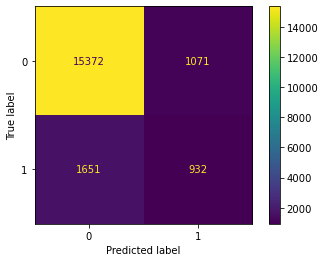

In [125]:
cm = confusion_matrix(y_test, y_pred, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgbc.classes_)
disp.plot()

In [126]:
# Feature importances:

importances = xgbc.feature_importances_


sorted_indices = np.argsort(importances)[::-1][:10]
 


indices = importances.argsort()[::-1][:10] # get the indices of the top 10 most important features
for i in indices:
    print(f"{i+1}. {X_train.columns[i]}: {round(importances[i], 2)}")
#fig, ax = plt.subplots(figsize=(20, 14)) 
#plt.title('Feature Importance')
#plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
#plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
#plt.tight_layout()
#plt.show()

6. stations_count: 0.12999999523162842
8. INDEGREE: 0.11999999731779099
7. PAGERANK: 0.09000000357627869
9. OUTDEGREE: 0.07999999821186066
5. morning_rush: 0.05999999865889549
20. month_8.0: 0.05000000074505806
4. dep_hour_origin: 0.03999999910593033
12. month_11.0: 0.03999999910593033
19. month_7.0: 0.03999999910593033
11. month_10.0: 0.029999999329447746


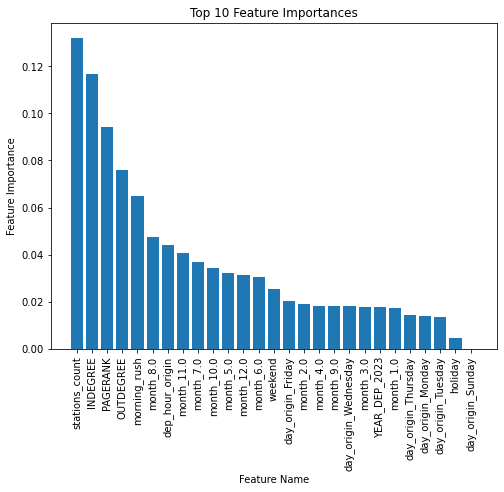

In [127]:
# Get feature importances and sort them in descending order
importances = xgbc.feature_importances_
indices = np.argsort(importances)[::-1]

# Select the top 30 features
top_indices = indices[:30]
top_importances = importances[top_indices]

# Get the corresponding feature names
feature_names = X_train.columns
top_feature_names = [feature_names[i] for i in top_indices]

# Plot the top 30 features and their importances
plt.figure(figsize=(8,6))
plt.bar(range(len(top_importances)), top_importances)
plt.xticks(range(len(top_importances)), top_feature_names, rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.show()

In [128]:
# Create an explainer object for the random forest classifier
explainer = shap.TreeExplainer(xgbc)

# Calculate the SHAP values for a single instance
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


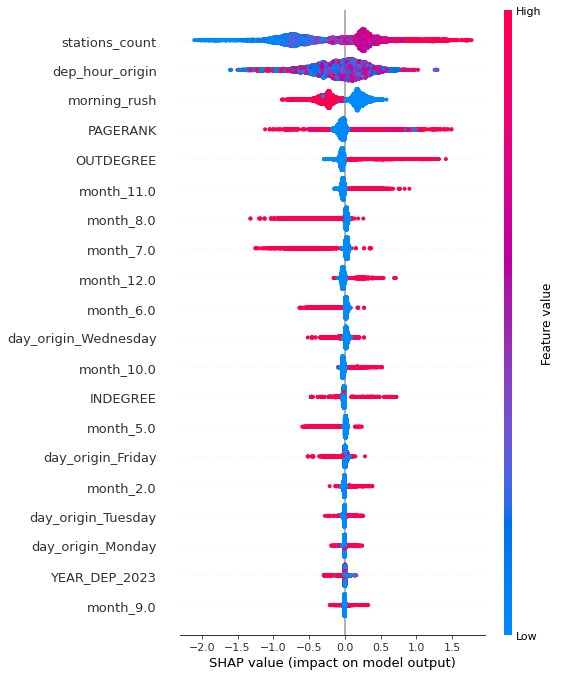

<Figure size 432x288 with 0 Axes>

In [129]:
# get summary plot
shap.summary_plot(shap_values, X_test, max_display=20)
plt.tight_layout()

## Explanation of observed: Force Plots

In [110]:

# example array of predicted probabilities
# find the indexes of the ten highest and lowest values
top_indexes = y_pred_proba.argsort()[-10:][::-1]
bottom_indexes = y_pred_proba.argsort()[:10]

print("Indexes of top 10 values:", top_indexes)
print("Indexes of bottom 10 values:", bottom_indexes)



Indexes of top 10 values: [10860 17321  3742  2576   797 10823  7813  9522 18824 10159]
Indexes of bottom 10 values: [ 4925  6670 16034 17748  4620  4505  9134  5519  5761 15315]


In [111]:
# high example
print(y_test[top_indexes[2]])
shap.force_plot(explainer.expected_value, shap_values[top_indexes[2],:], X_test.iloc[top_indexes[2],:], link="logit")

1


Exception: Length of features is not equal to the length of shap_values!

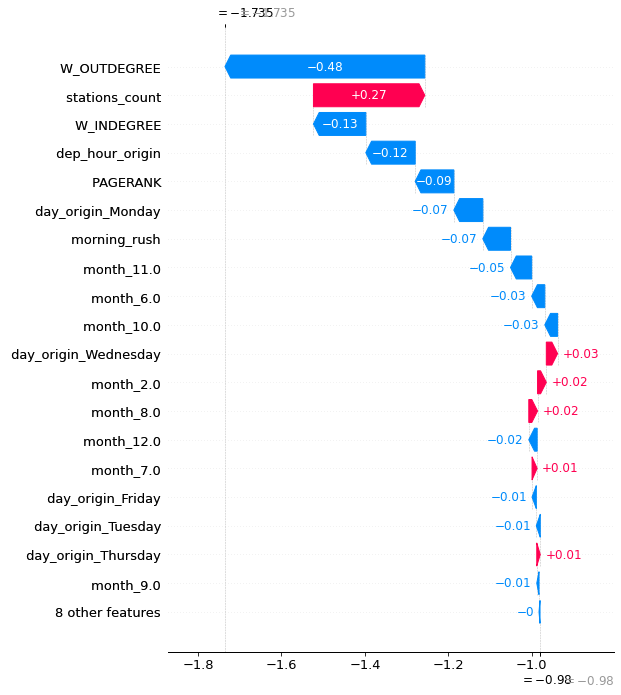

In [95]:
feature = X_test.columns.to_list() 
feature_string = []
for element in feature:
    feature_string.append(str(element))
shap.plots._waterfall.waterfall_legacy(explainer.expected_value,
                                       shap_values[4],
                                       X_test.values[4],
                                       feature_names=feature_string,
                                       max_display=20)

In [96]:
# low example
print(y_test[bottom_indexes[0]])
shap.force_plot(explainer.expected_value, shap_values[bottom_indexes[0],:], X_test.iloc[bottom_indexes[0],:], link="logit")

0


In [108]:
# random example
print(y_test[123])
shap.force_plot(explainer.expected_value, shap_values[123,:], X_test.iloc[123,:], link="logit")

0


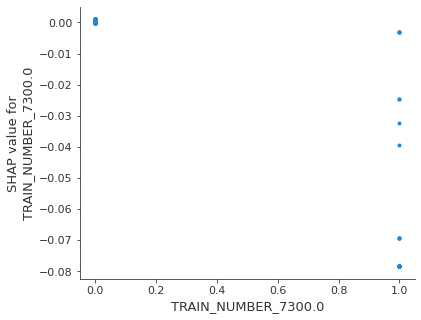

In [109]:
# The first argument is the index of the feature we want to plot
# The second argument is the matrix of SHAP values (it is the same shape as the data matrix)
# The third argument is the data matrix (a pandas dataframe or numpy array)
shap.dependence_plot(X_test.columns.get_loc('TRAIN_NUMBER_7300.0'), shap_values, X_test, interaction_index=None)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


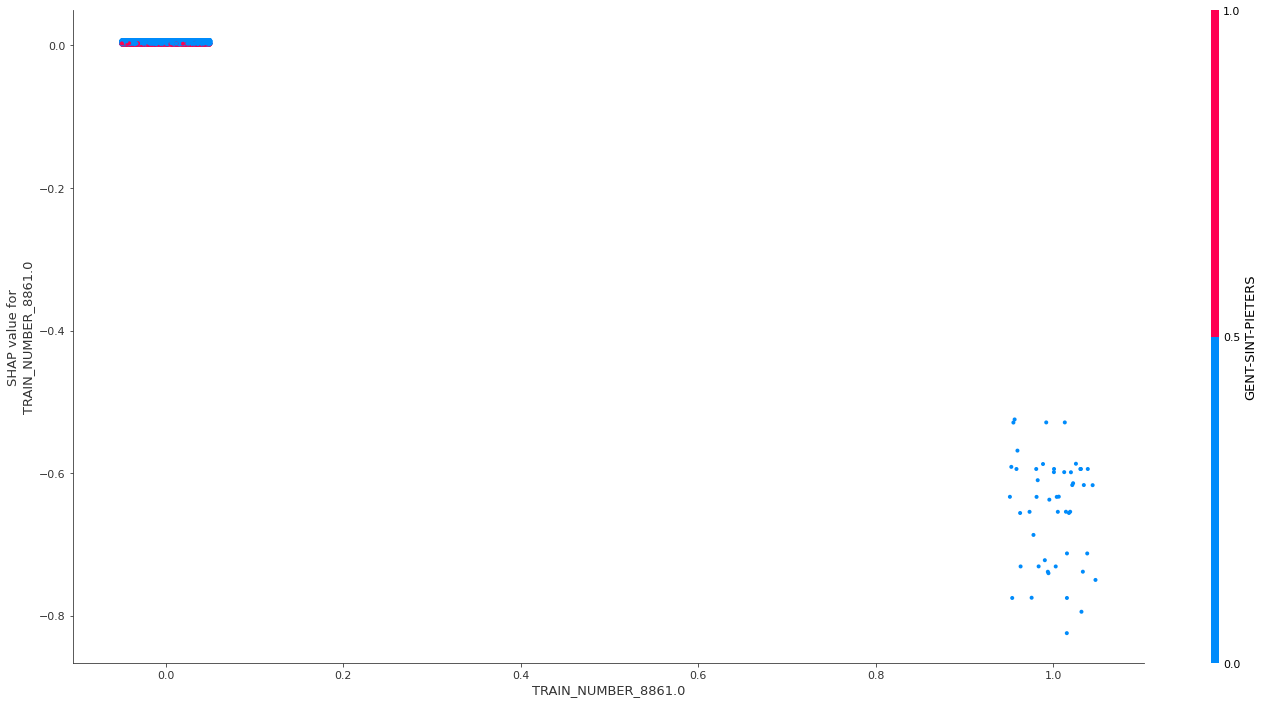

In [ ]:
# check shap and interaction effects
shap_values = explainer.shap_values(X_test)
for feat_name in  ['TRAIN_NUMBER_8861.0']:#X_train.columns[sorted_indices][:20]:
    shap.dependence_plot(f"{feat_name}", shap_values, X_test, show = False, x_jitter = .1)

    plt.gcf().set_size_inches(24, 12)
    # Show the plot
    plt.show()